# Setup

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from pandas_analysis import load_all_csv, IATA_TO_NAME

df = load_all_csv()

# 1. Gemiddeld goedkoopste of duurste vliegtuigmaatschappij?

In [19]:
data = df.copy(deep=True)
airline_prices = data.groupby('airline_iata_code')['price'].mean().reset_index()
airline_prices_sorted = airline_prices.sort_values(by='price', ascending=True)
airline_prices_sorted['airline_iata_code'] = airline_prices_sorted['airline_iata_code'].apply(lambda x: IATA_TO_NAME[x])
cheapest_airline = airline_prices_sorted.iloc[0]
most_expensive_airline = airline_prices_sorted.iloc[-1]

In [20]:
print(f"The cheapest airline on average is {cheapest_airline['airline_iata_code']} with an average price of {cheapest_airline['price']:.2f}")
print(f"The most expensive airline on average is {most_expensive_airline['airline_iata_code']} with an average price of {most_expensive_airline['price']:.2f}")

The cheapest airline on average is Ryanair with an average price of 115.72
The most expensive airline on average is Tui fly with an average price of 200.63


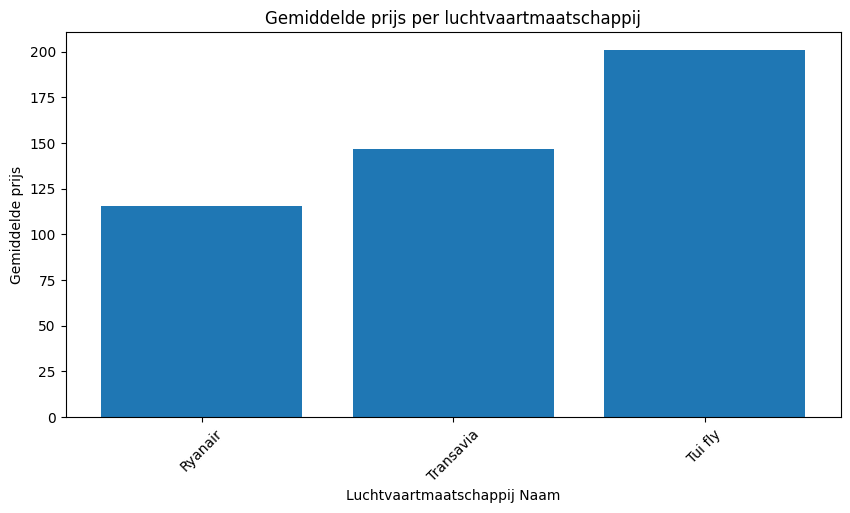

In [21]:
plt.figure(figsize=(10, 5))
plt.bar(airline_prices_sorted['airline_iata_code'], airline_prices_sorted['price'])
plt.xlabel('Luchtvaartmaatschappij Naam')
plt.ylabel('Gemiddelde prijs')
plt.title('Gemiddelde prijs per luchtvaartmaatschappij')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# 2. Hoe vaak vliegt elke vliegtuigmaatschappij per week naar elk van de bestemmingen?

In [22]:
data = df.copy(deep=True)
data['departure_date'] = pd.to_datetime(data['departure_date'])
data = data.drop_duplicates(subset=['flight_id', 'departure_date'])
data['week_number'] = data['departure_date'].dt.isocalendar().week
unique_airlines = data['airline_iata_code'].unique()

In [23]:
def plot_airline_chart(airline_data, airline_code):
    grouped_data = airline_data.groupby(['arrival_airport_iata_code', 'week_number']).size().reset_index(name='count')
    weekly_data = grouped_data.groupby('arrival_airport_iata_code')['count'].mean().reset_index()
    
    ax = weekly_data.plot(x='arrival_airport_iata_code', y='count', kind='bar', figsize=(8, 6))
    plt.ylabel('Aantal Vluchten per Week')
    plt.xlabel('Bestemming IATA Code')
    plt.title(f'Aantal Vluchten per Week voor {IATA_TO_NAME[airline_code]} per Bestemming')
    plt.show()

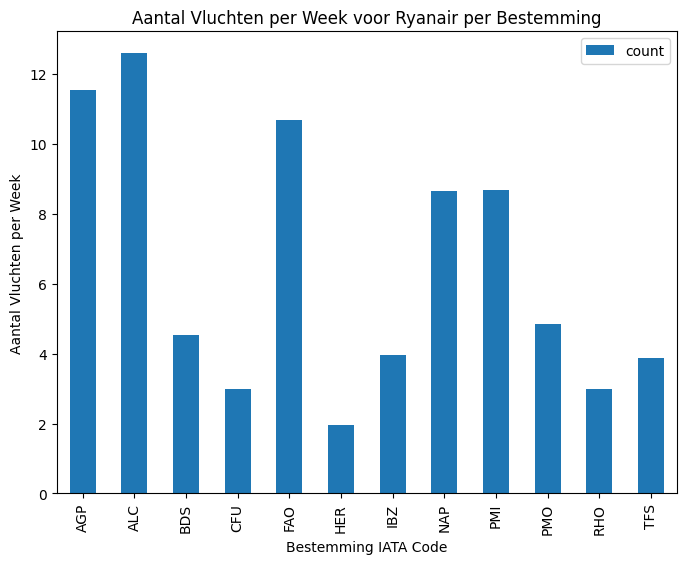

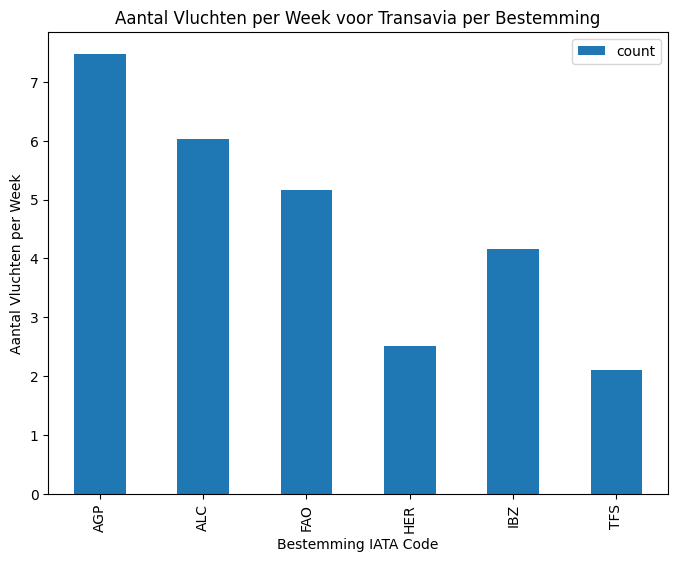

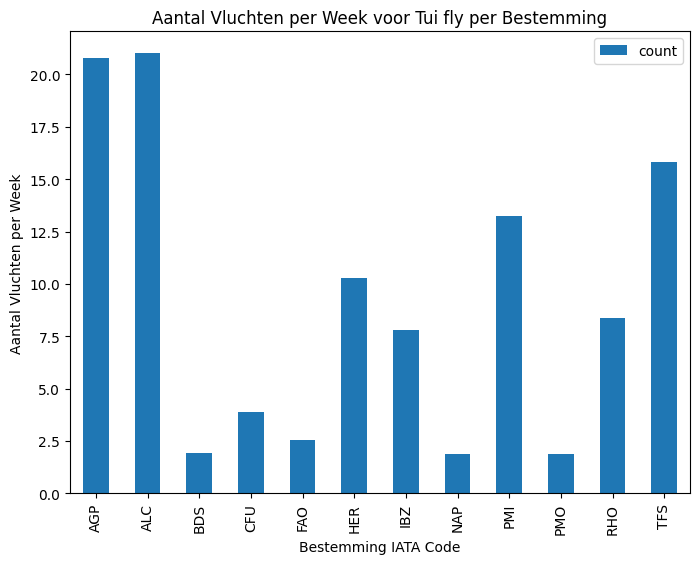

In [24]:
for airline_code in unique_airlines:
    airline_data = data[data['airline_iata_code'] == airline_code]
    plot_airline_chart(airline_data, airline_code)

# 3. Welke vlucht biedt de goedkoopste vlucht aan?
#### Dataframe filteren door enkel rijen over te laten waar de tijd tussen departure_date en scrape_date niet te groot en niet te klein is

In [25]:
def mask_func(x):
    dif = (dt.strptime(x["departure_date"], "%Y-%m-%d") - dt.strptime(x["scrape_date"], "%Y-%m-%d")).days
    return (dif > 14 and dif < 31)

data = df.copy(deep=True)
correct_data = data[data.apply(mask_func, axis=1)]

#### Minimumprijs berekenen, en rijen tonen die dezelfde prijs hebben

In [26]:
correct_data[correct_data["price"] == correct_data["price"].min()]

,flight_id,flightnumber,departure_date,arrival_date,departure_time,arrival_time,duration,number_of_stops,airline_iata_code,departure_airport_iata_code,arrival_airport_iata_code,scrape_date,available_seats,price
55659,FR_CRL_NAP_2023-05-09_FR1302,FR1302,2023-05-09,2023-05-09,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-10,1,19.99
55667,FR_CRL_PMI_2023-05-09_FR7831,FR7831,2023-05-09,2023-05-09,06:35,08:45,02:10,0,FR,CRL,PMI,2023-04-10,4,19.99
55670,FR_CRL_NAP_2023-05-10_FR1302,FR1302,2023-05-10,2023-05-10,16:35,18:50,02:15,0,FR,CRL,NAP,2023-04-10,2,19.99
80967,FR_CRL_NAP_2023-05-09_FR1302,FR1302,2023-05-09,2023-05-09,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-09,3,19.99
80975,FR_CRL_PMI_2023-05-09_FR7831,FR7831,2023-05-09,2023-05-09,06:35,08:45,02:10,0,FR,CRL,PMI,2023-04-09,-1,19.99
86156,FR_CRL_NAP_2023-05-23_FR1302,FR1302,2023-05-23,2023-05-23,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-23,-1,19.99
120201,FR_CRL_NAP_2023-05-23_FR1302,FR1302,2023-05-23,2023-05-23,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-24,4,19.99


#### Conclusie:
- Elke vlucht met de minimumprijs wordt uitgevoerd door Ryanair.
- De vluchten vertrekken enkel van charleroi, en vliegen enkel naar napoli en palma de mallorca

# 4. Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen?¶